In [1]:
#---This program is used to forecast 1 week CDRs based on 55 previous days' data

#---Install these bibs so the program works properly
import tensorflow as tf
from keras.models import Sequential
from keras import layers
from keras.layers import *
from keras.callbacks import ModelCheckpoint
from keras.losses import MeanSquaredError
from keras.losses import MeanAbsoluteError
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam
from keras.models import load_model
from numpy import loadtxt
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

2024-09-20 01:22:13.189467: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#--Loading Cell_ID vector, whose elements tell from which ID the matrix_TS row is the corresponding time-series

Cell_ID = loadtxt('ID_labels.csv', delimiter=',') 
df = pd.read_csv('matrixTS.csv',header=None)
df.head(6)


,0,1,2,3,4,5,6,7,8,9,...,1478,1479,1480,1481,1482,1483,1484,1485,1486,1487
0,13,11,8,7,8,9,11,12,13,18,...,23.0,17.0,20.0,16.0,16.0,18.0,19.0,21.0,17.0,13.0
1,13,11,10,7,6,9,11,11,13,17,...,22.0,15.0,20.0,15.0,15.0,18.0,20.0,19.0,17.0,13.0
2,15,11,9,11,9,8,12,18,23,31,...,6.0,9.0,9.0,11.0,8.0,7.0,7.0,8.0,7.0,5.0
3,12,11,7,9,6,6,8,15,12,23,...,14.0,12.0,17.0,17.0,15.0,14.0,12.0,13.0,14.0,10.0
4,10,8,11,7,8,8,12,16,16,16,...,28.0,26.0,23.0,26.0,27.0,19.0,18.0,20.0,14.0,18.0
5,11,8,7,6,8,8,6,7,12,14,...,14.0,13.0,12.0,14.0,14.0,12.0,12.0,16.0,11.0,10.0


In [3]:
#--Defines the Cell ID to be forecasted, size of training data

days = 62 #Train and validation sizes need to be changed if this value is tunned
matrix = df.to_numpy()

#-- This part is to get the cell ID time-series of IDs that surround 1051 [1050, 1052, 1150, 1151, 1152]
ID_1051=60
cells = [1050, 1052, 1150, 1151, 1152]
pos = []

for item in cells:
    for i in range (0,len(Cell_ID)):
        if item == Cell_ID[i]:
            pos.append(i)
            break
print('1050, 1052, 1150, 1151, 1152:',Cell_ID[pos[0]], Cell_ID[pos[1]], Cell_ID[pos[2]], Cell_ID[pos[3]], Cell_ID[pos[4]])

TS_950 = np.array(loadtxt('CellID950.csv', delimiter=','))
TS_951 = np.array(loadtxt('CellID951.csv', delimiter=','))
TS_952 = np.array(loadtxt('CellID952.csv', delimiter=','))

TS_1050 = matrix[pos[0]][:]
TS_1051 = matrix[ID_1051][:] #-This is the one to predict
TS_1052 = matrix[pos[1]][:]
TS_1150 = matrix[pos[2]][:]
TS_1151 = matrix[pos[3]][:]
TS_1152 = matrix[pos[4]][:]

#--Spliting the data set into Training/Validating/Testing
#--Standardizing the time-series
train_size = 24*50 
validation_size = 24*5

mean_TS_950 = TS_950[:train_size].mean() #--Considering just the training part
std_TS_950 = TS_950[:train_size].std() #--Considering just the training part

mean_TS_951 = TS_951[:train_size].mean() #--Considering just the training part
std_TS_951 = TS_951[:train_size].std() #--Considering just the training part

mean_TS_952 = TS_952[:train_size].mean() #--Considering just the training part
std_TS_952 = TS_952[:train_size].std() #--Considering just the training part

mean_TS_1050 = TS_1050[:train_size].mean() #--Considering just the training part
std_TS_1050 = TS_1050[:train_size].std() #--Considering just the training part

mean_TS_1051 = TS_1051[:train_size].mean() #--Considering just the training part
std_TS_1051 = TS_1051[:train_size].std() #--Considering just the training part

mean_TS_1052 = TS_1052[:train_size].mean() #--Considering just the training part
std_TS_1052 = TS_1052[:train_size].std() #--Considering just the training part

mean_TS_1150 = TS_1150[:train_size].mean() #--Considering just the training part
std_TS_1150 = TS_1150[:train_size].std() #--Considering just the training part

mean_TS_1151 = TS_1151[:train_size].mean() #--Considering just the training part
std_TS_1151 = TS_1151[:train_size].std() #--Considering just the training part

mean_TS_1152 = TS_1152[:train_size].mean() #--Considering just the training part
std_TS_1152 = TS_1152[:train_size].std() #--Considering just the training part


Norm_TS_950 = (TS_950 - mean_TS_950) / std_TS_950
Norm_TS_951 = (TS_951 - mean_TS_951) / std_TS_951
Norm_TS_952 = (TS_952 - mean_TS_952) / std_TS_952

Norm_TS_1050 = (TS_1050 - mean_TS_1050) / std_TS_1050
Norm_TS_1051 = (TS_1051 - mean_TS_1051) / std_TS_1051
Norm_TS_1052 = (TS_1052 - mean_TS_1052) / std_TS_1052

Norm_TS_1150 = (TS_1150 - mean_TS_1150) / std_TS_1150
Norm_TS_1151 = (TS_1151 - mean_TS_1151) / std_TS_1151
Norm_TS_1152 = (TS_1152 - mean_TS_1152) / std_TS_1152

1050, 1052, 1150, 1151, 1152: 1050.0 1052.0 1150.0 1151.0 1152.0


Text(0, 0.5, 'CDR')

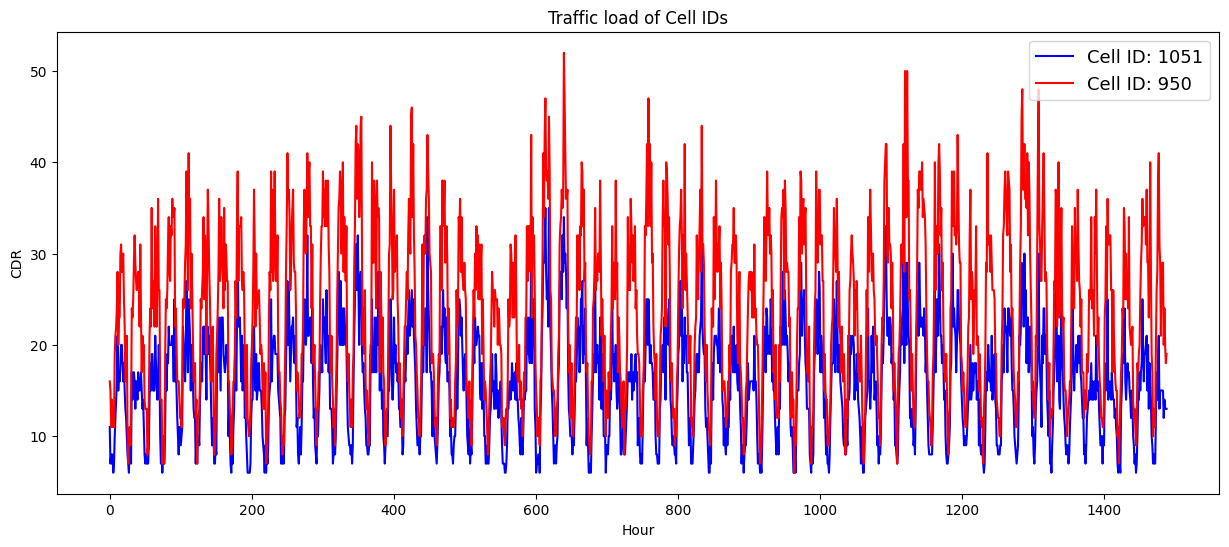

In [4]:
#---Plot of the Cell ID CDR
hour = np.linspace(0,24*days,24*days)

plt.figure(figsize=(15,6))
plt.title('Traffic load of Cell IDs') 
plt.plot(hour,TS_1051,'b',label="Cell ID: %d" % (Cell_ID[ID_1051]))
plt.plot(hour,TS_950,'r',label="Cell ID: 950")
plt.legend(loc='upper right',fontsize=13)
plt.xlabel("Hour")
plt.ylabel("CDR")

## Constructing the 3D tensor and respectives Outputs

In [5]:
tensor = []

for i in range(0,len(TS_950)):
    tensor.append([[Norm_TS_1150[i], Norm_TS_1151[i], Norm_TS_1152[i]], 
                        [Norm_TS_1050[i], Norm_TS_1051[i], Norm_TS_1052[i]],
                        [Norm_TS_950[i], Norm_TS_951[i], Norm_TS_952[i]]])


In [6]:
#---This function creates the sliding window to construct the training data set. 

def df_to_X_y(df,window_size):
    df_as_np = df
    X = []
    y = []
    for i in range(len(tensor)-window_size):
        row = [a for a in df_as_np[i:i+window_size]] 
        X.append(row)
        y.append(df_as_np[i+window_size])
    return np.array(X), np.array(y)

#-X contains 1464 tensors with 24 matrices (24 hours) of dimension 3x3 (IDs surrounding ID 1051- see Figure in the Survey Paper)
#-y contains 1464 matrices of dimension 3x3 used in the training

In [7]:
WINDOW_SIZE = 24
X,y = df_to_X_y(tensor,WINDOW_SIZE)
print('Initial Shape', X.shape, y.shape)

y_flatten = []
for item in y:
    y_flatten.append(item.flatten())

y_flatten = np.array(y_flatten)
print('Final Shape', X.shape, y.shape)

Initial Shape (1464, 24, 3, 3) (1464, 3, 3)
Final Shape (1464, 24, 3, 3) (1464, 3, 3)


In [8]:
#---Reshape tensor X
X = tf.expand_dims(X,axis=4)

2024-09-20 01:22:19.997906: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-20 01:22:20.070477: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-20 01:22:20.070522: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-20 01:22:20.074350: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-20 01:22:20.074412: I external/local_xla/xla/stream_executor

## Splitting data to training and testing

In [9]:
X_train, y_train = X[:train_size], y_flatten[:train_size]
X_val, y_val = X[train_size:(train_size+validation_size)], y_flatten[train_size:(train_size+validation_size)]

X_train.shape, X_val.shape

(TensorShape([1200, 24, 3, 3, 1]), TensorShape([120, 24, 3, 3, 1]))

## Constructing Simple CNN model

In [10]:
X_train[0].shape

TensorShape([24, 3, 3, 1])

In [11]:
model1 = Sequential()

#-Comment or uncomment lines to insert/remove layers of the CNN
#-Change the number of neurons inside each layers

d=1 # Kernel size in time-dimension
model1.add(layers.Conv3D(32, (d, 2, 2), activation='relu', padding='same', input_shape=(24, 3, 3, 1)))
model1.add(layers.AveragePooling3D((2, 2, 2),padding='same'))

model1.add(layers.Conv3D(32, (d, 2, 2), activation='relu',padding='valid'))
model1.add(layers.AveragePooling3D((2, 1, 1),padding='valid'))

model1.add(layers.Flatten())
model1.add(Dense(32,'relu'))
model1.add(Dense(9,'linear'))

model1.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 24, 3, 3, 32)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling3d               │ (None, 12, 2, 2, 32)   │             0 │
│ (AveragePooling3D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 12, 1, 1, 32)   │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling3d_1             │ (None, 6, 1, 1, 32)    │             0 │
│ (AveragePooling3D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │           297 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,761 (42.04 KB)

 Trainable params: 10,761 (42.04 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
#--Model Training

#-Set the hyperparemeters according to your application: learning_rate, epochs, batch size
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
model1.fit(X_train,y_train, validation_data=(X_val,y_val),epochs=1000, batch_size=32)

Epoch 1/1000


I0000 00:00:1726795342.171247   52436 service.cc:145] XLA service 0x7f3974004670 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726795342.171528   52436 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2024-09-20 01:22:22.226299: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-20 01:22:22.448187: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906


35/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0627 - root_mean_squared_error: 1.0307

I0000 00:00:1726795344.129218   52436 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - loss: 1.0567 - root_mean_squared_error: 1.0279 - val_loss: 1.0394 - val_root_mean_squared_error: 1.0273
Epoch 2/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9433 - root_mean_squared_error: 0.9711 - val_loss: 0.9804 - val_root_mean_squared_error: 0.9976
Epoch 3/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8696 - root_mean_squared_error: 0.9323 - val_loss: 0.9044 - val_root_mean_squared_error: 0.9580
Epoch 4/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7639 - root_mean_squared_error: 0.8740 - val_loss: 0.7970 - val_root_mean_squared_error: 0.8992
Epoch 5/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6286 - root_mean_squared_error: 0.7926 - val_loss: 0.6710 - val_root_mean_squared_error: 0.8248
Epoch 6/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5201 - root_mean_squared_error: 0.7209 - val_loss: 0.5548 - val_root_mean_squared_error: 0.7495
Epoch 7/1000
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.40

In [13]:
#----Predictions: the prediction of one step becomes input for the next one

input_pred_tensor = np.array(X_val[X_val.shape[0]-1]) # last position of validation tensor
input_pred_tensor = tf.expand_dims(input_pred_tensor,axis=0)
prediction_ID_1051 = []

N_day_pred = 7
for i in range(0,24*N_day_pred):
    prediction = model1.predict(input_pred_tensor)
    new_values = [[[prediction[0][0]],[prediction[0][1]],[prediction[0][2]]],
                 [ [prediction[0][3]],[prediction[0][4]],[prediction[0][5]]],
                 [ [prediction[0][6]],[prediction[0][7]],[prediction[0][8]]]]
    
    prediction_ID_1051.append(prediction[0][4])
    
    #Erase first position and add new values to the last one
    input_pred_tensor = np.array(input_pred_tensor[0][1:])
    input_pred_tensor = input_pred_tensor.tolist()
    input_pred_tensor.append(new_values)
    input_pred_tensor = np.array(input_pred_tensor)
    input_pred_tensor = tf.expand_dims(input_pred_tensor,axis=0)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━

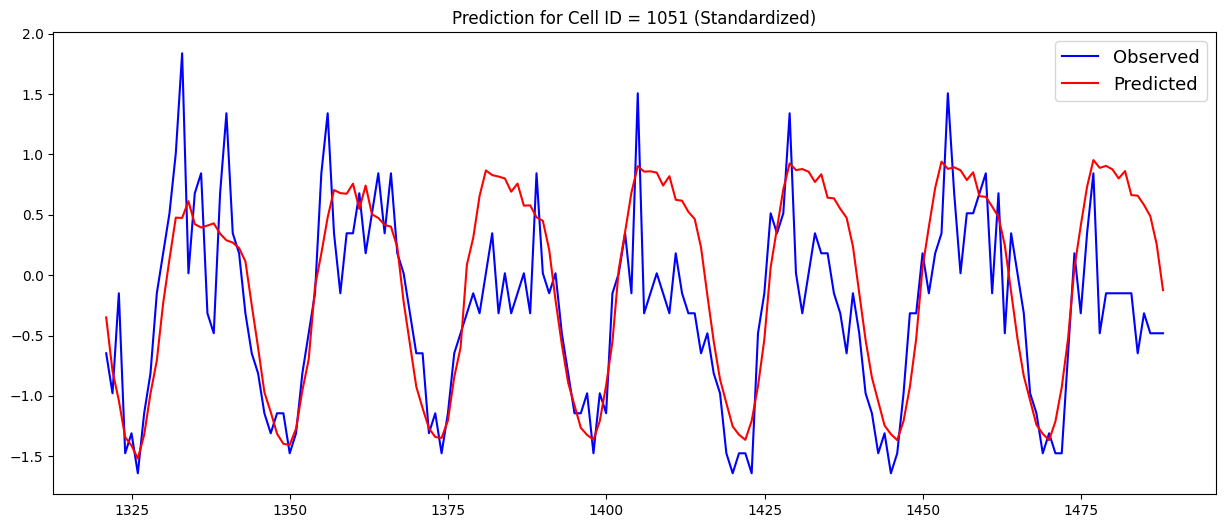

In [14]:
# Plotting the predictions
prediction_ID_1051 = np.array(prediction_ID_1051)

plt.figure(figsize=(15,6))
plt.title('Prediction for Cell ID = %d (Standardized)' % (Cell_ID[60])) 
plt.plot(hour[(train_size+validation_size):],Norm_TS_1051[(train_size+validation_size):],'b',label="Observed")
plt.plot(hour[(train_size+validation_size):], prediction_ID_1051,'r',label="Predicted")
plt.legend(loc='upper right',fontsize=13)


In [15]:
#---Non-standardized prediction
NN_prediction_ID_1051 = prediction_ID_1051*std_TS_1051+mean_TS_1051

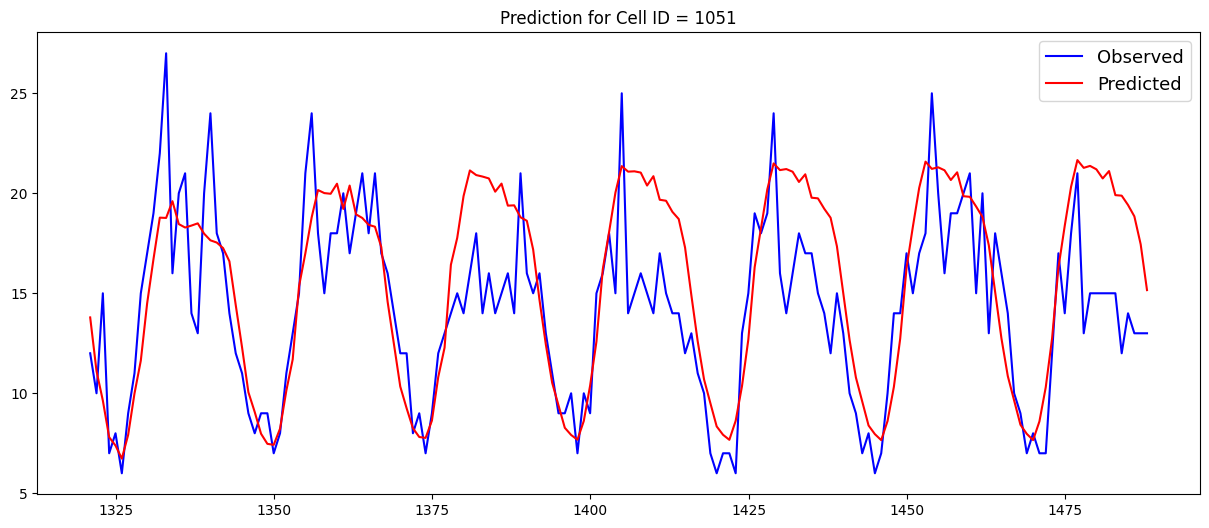

In [16]:
#---Plotting the predictions
prediction_ID_1051 = np.array(prediction_ID_1051)

plt.figure(figsize=(15,6))
plt.title('Prediction for Cell ID = %d' % (Cell_ID[60])) 
plt.plot(hour[(train_size+validation_size):],TS_1051[(train_size+validation_size):],'b',label="Observed")
plt.plot(hour[(train_size+validation_size):], NN_prediction_ID_1051,'r',label="Predicted")
plt.legend(loc='upper right',fontsize=13)

In [17]:
#---Accuracy results

MAE = mean_absolute_error(NN_prediction_ID_1051,TS_1051[(train_size+validation_size):])
MSE = mean_squared_error(NN_prediction_ID_1051,TS_1051[(train_size+validation_size):])
print('MAE:', "%.3f" % MAE)
print('MSE:', "%.3f" % MSE)

MAE: 2.742
MSE: 11.599
